# Image Classification (Illustation or Manga)

## Introduction

This ipynb notebook is created to document the results of my self-study in `Deep Learning`. 
The topic I will be studying is `Image Classification using Supervised Learning` method.

The image classification system will categorize images in a simple manner by dividing them into:

- `Illustration`: Images that do not contain any accompanying text or dialogue.
- `Manga`: Images that do contain text or dialogue.

Examples of `Illustration` and `Manga` images.

<div style="display: flex; justify-content: center;">
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/IMAGE/ILLUST%20Sample1.jpg" style="max-height:300px;width:auto">
      <figcaption>Illustration</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/IMAGE/ILLUST%20Sample2.jpg" style="max-height:300px;width:auto">
      <figcaption>Illustration</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/IMAGE/MANGA%20Sample1.jpg" style="max-height:300px;width:auto">
      <figcaption>Manga</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/IMAGE/MANGA%20Sample2.jpg" style="max-height:300px;width:auto">
      <figcaption>Manga</figcaption>
    </figure>
  </div>
</div>

**NOTE** 
- This ipynb notebook primarily demonstrates the complete coding cycle for creating, training, and evaluating the model.

## Version

In [1]:
from module.utility.Initializer import Initializer
# Display version of TensorFlow and Python
Initializer.show_version()

# Display Version of Nvidia Driver and CUDA
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Mon Nov  6 15:18:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              20W /  80W |    267MiB /  6144MiB |      5%      Default |
|                                         |     

## Configuration

In [2]:
import tensorflow as tf

CFG = {
    "fp16": False, # Use mixed precision training (True/False)
    "dataset_dir": ".\DATASET\ILLUSTRATION VS MANGA",
    "extension": [".jpg", ".png"],
    "image_size": 224, 
    "batch": 16, 
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-4), # First optimizer (lr=1e-4) for main training
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-4), # Second optimizer (lr=1e-5, decay=1e-4) for fine-tuning
    "loss": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

## Initializing

In [3]:
if CFG["fp16"]:
    Initializer.mixed_precision16()

Initializer.memory_growth()

## Dataset preparation

In [4]:
from module.utility.DirectoryProcessor import DirectoryProcessor
from pathlib import Path

def data_maker():
    # File path processing
    data_list = []
    label_set = set()
    path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extension"], include_sub_dir=True)

    for path in path_list:
        path_obj = Path(path)
        label = path_obj.parts[-2]
        data_list.append((path, label))
        label_set.add(label)
    
    label_list = list(sorted(label_set))

    return data_list, label_list

data_list, label_list = data_maker()

Total: 986 dataset including
ILLUSTRATION: 799
MANGA: 187
=====
Train: 336 dataset including
ILLUSTRATION: 168
MANGA: 168
Class weight: {'ILLUSTRATION': 1.0, 'MANGA': 1.0}
=====
Test: 38 dataset including
ILLUSTRATION: 19
MANGA: 19


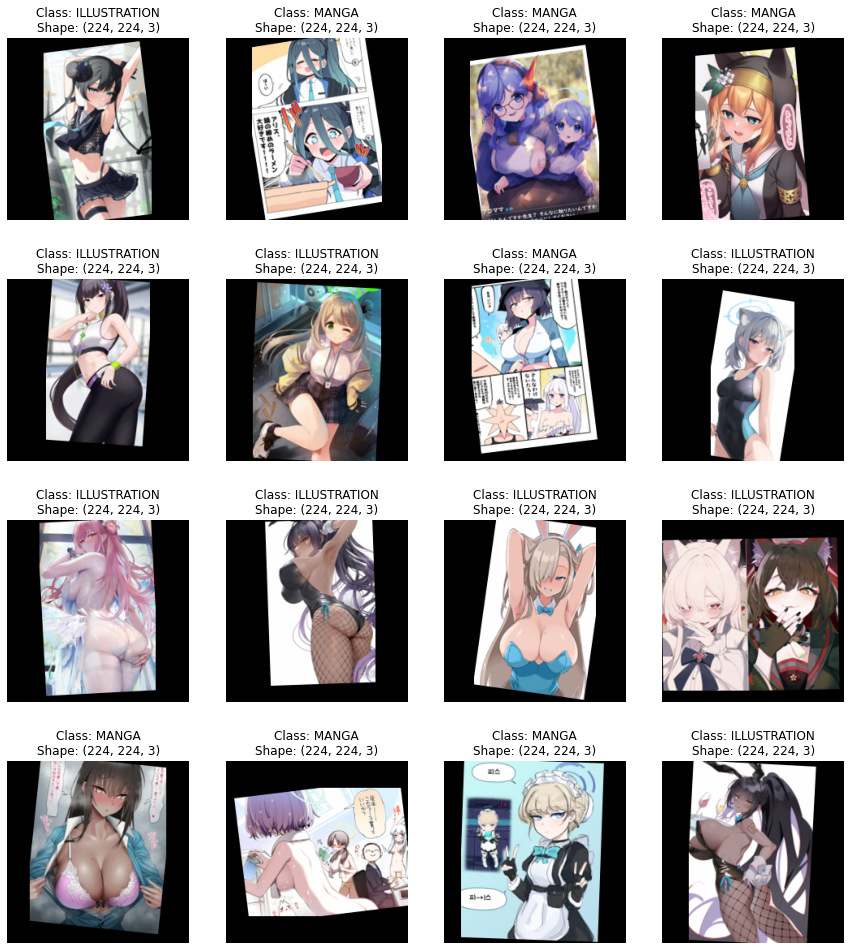

In [5]:
from module.image_classification.ImageDataGenerator import ImageDataGenerator
from module.image_classification.ImageVisualizer import ImageVisualizer as vis

# Calling data generator instance 
generator = ImageDataGenerator(
    input = data_list,
    image_size = CFG["image_size"],
    keep_aspect_ratio = True,
    label_mode = "onehot",
    horizontal_flip = False,
    vertical_flip = False,
    translate_range = 0.1,
    rotation_range = 10,
    border_method = "constant", # "constant" or "replicate"
    validation_split = 0.1,
)

# Generate dataset
#train, test = generator.generate_dataset_from_generator(batch_size=CFG["batch"], balance=True, train_drop_remainder=True) # for low memory
train, test = generator.generate_dataset_from_tensor_slices(batch_size=CFG["batch"], balance=True, train_drop_remainder=True) # for high memory

# Visualizing
vis.display_batch(train, label_list, figsize=(15, 17))

## Model creation

In [6]:
# Available models
#from model.VGGModel import VGG11, VGG13, VGG16, VGG19
#from model.ResnetModel import Resnet18, Resnet34, Resnet50, Resnet101, Resnet152
#from model.Res2NetModel import Res2Net50, Res2Net101, Res2Net152
#from model.ResNeXtModel import ResNeXt18, ResNeXt34, ResNeXt50, ResNeXt101, ResNeXt152
#from model.DenseNetModel import DenseNet121, DenseNet169, DenseNet201, DenseNet264
#from model.GooLeNetModel import Inception_v1, Inception_v1_BN
#from model.SqueezeNetModel import SqueezeNet, SqueezeNet_SimpleSkip, SqueezeNet_ComplexSkip

from model.ResnetModel import Resnet18

model = Resnet18(image_size=CFG["image_size"], num_class=len(label_list))
model.summary()

Model: "Resnet18_224x224_2Class"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        Input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________

## Model training

### Main training

In [7]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=10, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer1"], loss=CFG["loss"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train, test, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
21/21 [==============================] - 10s 165ms/step - loss: 0.6402 - accuracy: 0.6964 - val_loss: 18.7236 - val_accuracy: 0.5000
Epoch 2/1000
21/21 [==============================] - 3s 122ms/step - loss: 0.2823 - accuracy: 0.8810 - val_loss: 15.9497 - val_accuracy: 0.5000
Epoch 3/1000
21/21 [==============================] - 3s 124ms/step - loss: 0.1220 - accuracy: 0.9583 - val_loss: 5.4469 - val_accuracy: 0.5526
Epoch 4/1000
21/21 [==============================] - 3s 123ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 4.3760 - val_accuracy: 0.5526
Epoch 5/1000
21/21 [==============================] - 3s 125ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.9736 - val_accuracy: 0.6316
Epoch 6/1000
21/21 [==============================] - 3s 123ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 1.2216 - val_accuracy: 0.6842
Epoch 7/1000
21/21 [==============================] - 3s 124ms/step - loss: 0.0357 - accuracy: 0.9911 - val_loss: 1.8730 - val_accura

### Fine tuning

In [8]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=5, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer2"], loss=CFG["loss"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train, test, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 36
Epoch 37/1000
21/21 [==============================] - 6s 155ms/step - loss: 0.0158 - accuracy: 0.9970 - val_loss: 0.4408 - val_accuracy: 0.8684
Epoch 38/1000
21/21 [==============================] - 3s 128ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5910 - val_accuracy: 0.8421
Epoch 39/1000
21/21 [==============================] - 3s 127ms/step - loss: 0.0084 - accuracy: 0.9970 - val_loss: 0.2793 - val_accuracy: 0.8947
Epoch 40/1000
21/21 [==============================] - 3s 125ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.7165 - val_accuracy: 0.8421
Epoch 41/1000
21/21 [==============================] - 3s 125ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.1602 - val_accuracy: 0.7895
Epoch 42/1000
21/21 [==============================] - 3s 126ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 1.1691 - val_accuracy: 0.7895
Epoch 43/1000
21/21 [==============================] - 3s 124ms/step - loss: 0.0120 - accuracy: 

## Export model

In [9]:
model.save()

## Evaluation

### History graph

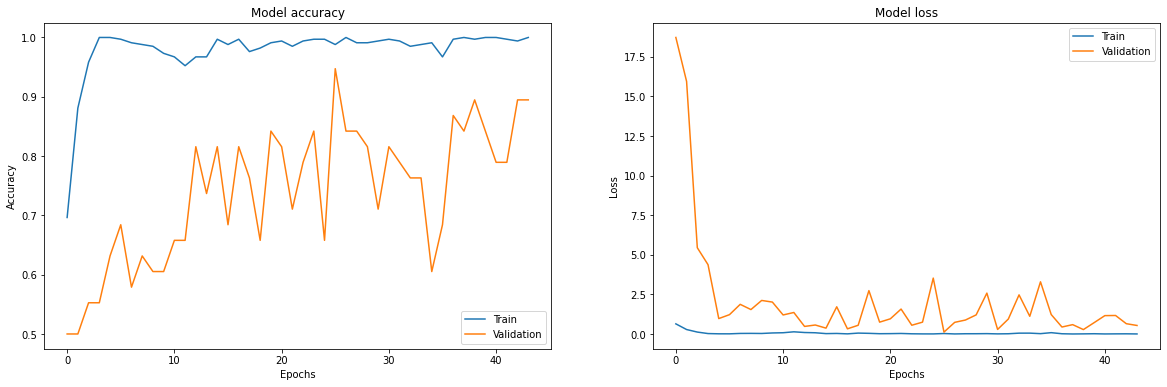

In [10]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(20, 6))
    
    # Summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

plot_training_history(model.history)

### GranCAM heatmap evaluation

Load model ... WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Complete
Generate GranCAM model ... Complete


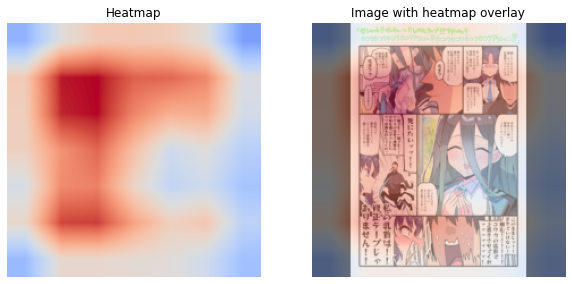

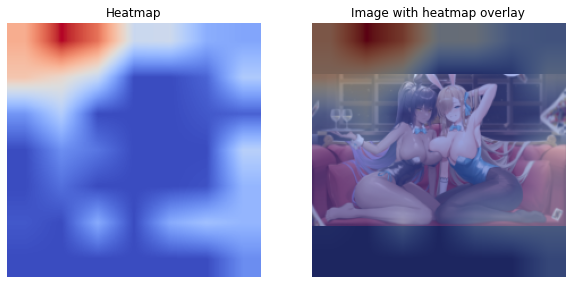

In [11]:
%reset -f
import matplotlib.pyplot as plt
import tensorflow as tf
from evaluate.GranCAM import GranCAM
from module.utility.Initializer import Initializer

# Initializing
Initializer.memory_growth()

# Configuration and Constants
CFG = {
    "h5": ".\export model\Resnet18_224x224_2Class.h5",
}

GRAN_MODEL = GranCAM(CFG["h5"])
_, HEIGHT, WIDTH, _ = GRAN_MODEL.model.input_shape

# Declare functions
def image_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, expand_animations=False)
    image = tf.image.resize(image, (HEIGHT, WIDTH),
                            preserve_aspect_ratio=True,
                            antialias=True)
    image = tf.image.resize_with_pad(image, HEIGHT, WIDTH)
    image = image / 255.0
    
    return image

def generate_heatmap(image_path):
    image = image_resize(image_path)

    heatmap = GRAN_MODEL.generate_heatmap(image, overlay=False)
    overlay = GRAN_MODEL.generate_heatmap(image, overlay=True)

    return heatmap, overlay

def plot_result(heatmap, overlay):
    plt.figure(figsize=(10,8))

    plt.subplot(1, 2, 1)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Image with heatmap overlay')
    plt.axis("off")

# Show results
manga_heatmap, manga_overlay = generate_heatmap('samples\GranCAM\MANGA.jpg')
illust_heatmap, illust_overlay = generate_heatmap('samples\GranCAM\ILLUSTRATION.jpg')
plot_result(manga_heatmap, manga_overlay)
plot_result(illust_heatmap, illust_overlay)

### Confusion matrix

Loading model ...
Model loaded successfully. No custom Keras layers detected.
Processing class prediction ...
289/289 [====================] - 41s 138ms/batch
Generating confusion matrix ... Complete
Generating text based classification report ... Complete
Complete
Classification Report
              precision    recall  f1-score   support

ILLUSTRATION       0.94      0.82      0.87      3992
       MANGA       0.36      0.66      0.47       622

    accuracy                           0.80      4614
   macro avg       0.65      0.74      0.67      4614
weighted avg       0.86      0.80      0.82      4614



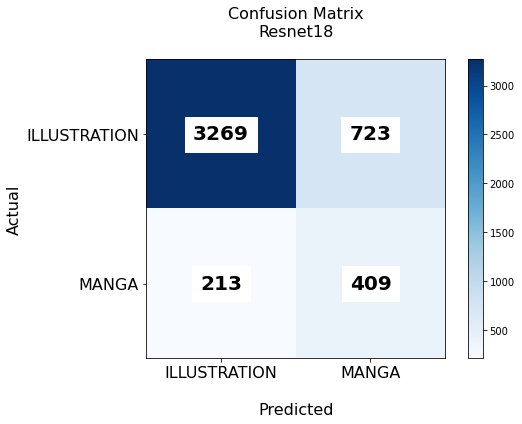

In [12]:
%reset -f

from module.utility.DirectoryProcessor import DirectoryProcessor
from evaluate.ConfusionMatrix import ConfusionMatrix
from pathlib import Path

CFG = {
    "dataset_dir": ".\DATASET MANAGER\Blue Archive",
    "extenstions": [".jpg", ".png"],
    "model1": {"h5":".\export model\Resnet18_224x224_2Class.h5",
               "name":"Resnet18"},
}

def data_maker():
    # File path processing
    data_list = []
    label_set = set()
    path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extenstions"], include_sub_dir=True)

    for path in path_list:
        path_obj = Path(path)
        label = path_obj.parts[-2]
        data_list.append((path, label))
        label_set.add(label)
    
    label_list = list(sorted(label_set))

    return data_list, label_list

data_list, label_list = data_maker()

report = ConfusionMatrix(
    h5_file=CFG["model1"]["h5"],
    model_name=CFG["model1"]["name"],
    data_list=data_list,
    label_list=label_list,
    force_batch=16,
)
report.print_report()

**NOTE** 
- The classification results are poor due to the low amount of dataset.